In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import torch

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
#ID Ïª¨Îüº Î∂ÑÎ¶¨
train = train.drop(columns=['ID'], axis = 1)
test = test.drop(columns=['ID'], axis = 1)

In [4]:
import re

def clean_valuation(val):
    if pd.isna(val):
        return None
    if 'Ïù¥ÏÉÅ' in val:
        # '6000Ïù¥ÏÉÅ' ‚Üí 6000
        return int(re.sub('[^0-9]', '', val))
    elif '-' in val:
        # '2500-3500' ‚Üí ÌèâÍ∑†Í∞í Í≥ÑÏÇ∞
        low, high = map(int, val.split('-'))
        return (low + high) / 2
    else:
        # Ïà´ÏûêÎ°ú Î≥ÄÌôò Í∞ÄÎä•Ìïú Í≤ΩÏö∞
        try:
            return float(val)
        except:
            return None


In [5]:
# ÏÑ§Î¶ΩÏó∞ÎèÑ -> Ïó∞Ï∞®Î°ú Î≥ÄÍ≤Ω
current_year = 2025

train['Ïó∞Ï∞®'] = current_year - train['ÏÑ§Î¶ΩÏó∞ÎèÑ']
test['Ïó∞Ï∞®'] = current_year - test['ÏÑ§Î¶ΩÏó∞ÎèÑ']

# ÏÑ§Î¶ΩÏó∞ÎèÑ Ï†úÍ±∞
train.drop(columns = ['ÏÑ§Î¶ΩÏó∞ÎèÑ'], inplace = True)
test.drop(columns = ['ÏÑ§Î¶ΩÏó∞ÎèÑ'], inplace = True)

category_features = ['Íµ≠Í∞Ä','Î∂ÑÏïº']
numeric_features = ['Ïó∞Ï∞®', 'Ìà¨ÏûêÎã®Í≥Ñ', 'ÏßÅÏõê Ïàò','Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)','Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)','Ïó∞Îß§Ï∂ú(ÏñµÏõê)','SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)', 'Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)']
bool_features = ['Ïù∏ÏàòÏó¨Î∂Ä','ÏÉÅÏû•Ïó¨Î∂Ä']

# Ìà¨ÏûêÎã®Í≥Ñ ÏàúÏÑúÎ•º Ïà´ÏûêÎ°ú Îß§Ìïë
investment_stage_map = {
    'Seed': 0,
    'Series A': 1,
    'Series B': 2,
    'Series C': 3,
    'IPO': 4,
    'Missing': -1
}

# Í≤∞Ï∏°Ïπò Î®ºÏ†Ä Ï≤òÎ¶¨ ÌõÑ Îß§Ìïë
train['Ìà¨ÏûêÎã®Í≥Ñ'] = train['Ìà¨ÏûêÎã®Í≥Ñ'].fillna('Missing').map(investment_stage_map)
test['Ìà¨ÏûêÎã®Í≥Ñ'] = test['Ìà¨ÏûêÎã®Í≥Ñ'].fillna('Missing').map(investment_stage_map)

# Í∏∞ÏóÖÍ∞ÄÏπò Î≥ÄÌôò
train['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] = train['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'].apply(clean_valuation)
test['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] = test['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'].apply(clean_valuation)

# LabelEncoder Í∞ùÏ≤¥Î•º Í∞Å Î≤îÏ£ºÌòï featureÎ≥ÑÎ°ú Îî∞Î°ú Ï†ÄÏû•ÌïòÏó¨ ÏÇ¨Ïö©
encoders = {}

# Î≤îÏ£ºÌòï Îç∞Ïù¥ÌÑ∞Î•º encoding
for feature in category_features:
    encoders[feature] = LabelEncoder()
    train[feature] = train[feature].fillna('Missing')
    test[feature] = test[feature].fillna('Missing')
    train[feature] = encoders[feature].fit_transform(train[feature])
    test[feature] = encoders[feature].transform(test[feature])

# Î∂àÎ¶¨Ïñ∏ Í∞íÏùÑ 0Í≥º 1Î°ú Î≥ÄÌôò ('Yes' ‚Üí 1, 'No' ‚Üí 0 ÏúºÎ°ú Î≥ÄÌôò)
bool_map = {'Yes': 1, 'No': 0}

for feature in bool_features:
    train[feature] = train[feature].map(bool_map)
    test[feature] = test[feature].map(bool_map)

# ÏàòÏπòÌòï Î≥ÄÏàò Í≤∞Ï∏°ÏπòÎ•º Ï§ëÍ∞ÑÍ∞íÏúºÎ°ú ÎåÄÏ≤¥
for feature in numeric_features:
    median_value = train[feature].median()
    train[feature] = train[feature].fillna(median_value)
    test[feature] = test[feature].fillna(median_value)

# TabNetÏö© Î≤îÏ£ºÌòï Î≥ÄÏàò Ïù∏Îç±Ïä§(cat_idxs) Î∞è Ï∞®Ïõê(cat_dims) ÏÑ§Ï†ï
features = [col for col in train.columns if col != 'ÏÑ±Í≥µÌôïÎ•†']
cat_idxs = [features.index(col) for col in category_features]
cat_dims = [train[col].max() + 1 for col in category_features]

In [5]:
# ÏÑ§Î¶ΩÏó∞ÎèÑ -> Ïó∞Ï∞®Î°ú Î≥ÄÍ≤Ω
current_year = 2025

train['Ïó∞Ï∞®'] = current_year - train['ÏÑ§Î¶ΩÏó∞ÎèÑ']
test['Ïó∞Ï∞®'] = current_year - test['ÏÑ§Î¶ΩÏó∞ÎèÑ']

# ÏÑ§Î¶ΩÏó∞ÎèÑ Ï†úÍ±∞
train.drop(columns = ['ÏÑ§Î¶ΩÏó∞ÎèÑ'], inplace = True)
test.drop(columns = ['ÏÑ§Î¶ΩÏó∞ÎèÑ'], inplace = True)

category_features = ['Íµ≠Í∞Ä','Î∂ÑÏïº']
numeric_features = ['Ïó∞Ï∞®', 'Ìà¨ÏûêÎã®Í≥Ñ', 'ÏßÅÏõê Ïàò','Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)','Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)','Ïó∞Îß§Ï∂ú(ÏñµÏõê)','SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)', 'Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)']
bool_features = ['Ïù∏ÏàòÏó¨Î∂Ä','ÏÉÅÏû•Ïó¨Î∂Ä']

# Ìà¨ÏûêÎã®Í≥Ñ ÏàúÏÑúÎ•º Ïà´ÏûêÎ°ú Îß§Ìïë
investment_stage_map = {
    'Seed': 0,
    'Series A': 1,
    'Series B': 2,
    'Series C': 3,
    'IPO': 4,
    'Missing': -1
}

# Í≤∞Ï∏°Ïπò Î®ºÏ†Ä Ï≤òÎ¶¨ ÌõÑ Îß§Ìïë
train['Ìà¨ÏûêÎã®Í≥Ñ'] = train['Ìà¨ÏûêÎã®Í≥Ñ'].map(investment_stage_map)
test['Ìà¨ÏûêÎã®Í≥Ñ'] = test['Ìà¨ÏûêÎã®Í≥Ñ'].map(investment_stage_map)

# Í∏∞ÏóÖÍ∞ÄÏπò Î≥ÄÌôò
train['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] = train['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'].apply(clean_valuation)
test['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] = test['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'].apply(clean_valuation)

# LabelEncoder Í∞ùÏ≤¥Î•º Í∞Å Î≤îÏ£ºÌòï featureÎ≥ÑÎ°ú Îî∞Î°ú Ï†ÄÏû•ÌïòÏó¨ ÏÇ¨Ïö©
encoders = {}

# Î≤îÏ£ºÌòï Îç∞Ïù¥ÌÑ∞Î•º encoding
for feature in category_features:
    encoders[feature] = LabelEncoder()
    train[feature] = train[feature].fillna('Missing')
    test[feature] = test[feature].fillna('Missing')
    train[feature] = encoders[feature].fit_transform(train[feature])
    test[feature] = encoders[feature].transform(test[feature])

# Î∂àÎ¶¨Ïñ∏ Í∞íÏùÑ 0Í≥º 1Î°ú Î≥ÄÌôò ('Yes' ‚Üí 1, 'No' ‚Üí 0 ÏúºÎ°ú Î≥ÄÌôò)
bool_map = {'Yes': 1, 'No': 0}

for feature in bool_features:
    train[feature] = train[feature].map(bool_map)
    test[feature] = test[feature].map(bool_map)

# # ÏàòÏπòÌòï Î≥ÄÏàò Í≤∞Ï∏°ÏπòÎ•º Ï§ëÍ∞ÑÍ∞íÏúºÎ°ú ÎåÄÏ≤¥
# for feature in numeric_features:
#     median_value = train[feature].median()
#     train[feature] = train[feature].fillna(median_value)
#     test[feature] = test[feature].fillna(median_value)

# TabNetÏö© Î≤îÏ£ºÌòï Î≥ÄÏàò Ïù∏Îç±Ïä§(cat_idxs) Î∞è Ï∞®Ïõê(cat_dims) ÏÑ§Ï†ï
features = [col for col in train.columns if col != 'ÏÑ±Í≥µÌôïÎ•†']
cat_idxs = [features.index(col) for col in category_features]
cat_dims = [train[col].max() + 1 for col in category_features]

In [6]:
for df in [train, test]:
    # 1Ïù∏Îãπ ÏßÄÌëú
    df['Ìà¨Ïûê_ÏßÅÏõêÏàò'] = df['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'] / df['ÏßÅÏõê Ïàò']
    df['Îß§Ï∂ú_ÏßÅÏõêÏàò'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / df['ÏßÅÏõê Ïàò']

    # ÎπÑÏú® ÏßÄÌëú
    df['Îß§Ï∂ú_Ìà¨Ïûê'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / df['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)']
    df['Ìà¨Ïûê_Í∏∞ÏóÖÍ∞ÄÏπò'] = df['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)'] / df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)']
    df['Îß§Ï∂ú_Í≥†Í∞ù'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / df['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)']

    # Ïä§ÏºÄÏùº Î≥ÄÌôò
    df['Ïó∞Ï∞®_Î£®Ìä∏'] = np.sqrt(df['Ïó∞Ï∞®'])

    # Ï∂îÍ∞Ä ÌååÏÉù ÌîºÏ≤ò
    df['Í∏∞ÏóÖÍ∞ÄÏπò_Ìà¨Ïûê'] = df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)'] / df['Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)']
    df['ÌåîÎ°úÏõå_Í≥†Í∞ù'] = df['SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)'] / df['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)']
    df['ÌåîÎ°úÏõå_Í∏∞ÏóÖÍ∞ÄÏπò'] = df['SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)'] / df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)']
    df['Í≥†Í∞ù_ÏßÅÏõêÏàò'] = df['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)'] / df['ÏßÅÏõê Ïàò']
    df['Îß§Ï∂ú_Í∏∞ÏóÖÍ∞ÄÏπò'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / df['Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)']
    df['Îß§Ï∂ú_Ïó∞Ï∞®'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / df['Ïó∞Ï∞®']
    df['Îß§Ï∂ú_ÌåîÎ°úÏõå'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / (df['SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)'] + 1e-6)


In [7]:
features += [
    'Ìà¨Ïûê_ÏßÅÏõêÏàò', 'Îß§Ï∂ú_ÏßÅÏõêÏàò', 'Îß§Ï∂ú_Ìà¨Ïûê',
    'Ìà¨Ïûê_Í∏∞ÏóÖÍ∞ÄÏπò', 'Îß§Ï∂ú_Í≥†Í∞ù', 'Ïó∞Ï∞®_Î£®Ìä∏',
    'Í∏∞ÏóÖÍ∞ÄÏπò_Ìà¨Ïûê', 'ÌåîÎ°úÏõå_Í≥†Í∞ù', 'ÌåîÎ°úÏõå_Í∏∞ÏóÖÍ∞ÄÏπò',
    'Í≥†Í∞ù_ÏßÅÏõêÏàò', 'Îß§Ï∂ú_Í∏∞ÏóÖÍ∞ÄÏπò', 'Îß§Ï∂ú_Ïó∞Ï∞®',
    'Îß§Ï∂ú_ÌåîÎ°úÏõå'
]


In [8]:
# features Î¶¨Ïä§Ìä∏ÏóêÏÑú Ï†úÍ±∞
features = [f for f in features if f not in ['Íµ≠Í∞Ä', 'Î∂ÑÏïº', 'Ìà¨ÏûêÎã®Í≥Ñ', 'Ïù∏ÏàòÏó¨Î∂Ä', 'ÏÉÅÏû•Ïó¨Î∂Ä', 'ÏßÅÏõê Ïàò', 'SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)']]


In [ ]:
# ÌèâÍ∑†Í∞íÏùÑ ÎîïÏÖîÎÑàÎ¶¨Î°ú Ï†ÄÏû•
Íµ≠Í∞ÄÎ≥Ñ_Ïó∞Îß§Ï∂ú_ÌèâÍ∑†_dict = train.groupby('Íµ≠Í∞Ä')['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'].mean().to_dict()
Î∂ÑÏïºÎ≥Ñ_Í≥†Í∞ùÏàò_ÌèâÍ∑†_dict = train.groupby('Î∂ÑÏïº')['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)'].mean().to_dict()

for df in [train, test]:
    Íµ≠Í∞Ä_ÌèâÍ∑† = df['Íµ≠Í∞Ä'].map(Íµ≠Í∞ÄÎ≥Ñ_Ïó∞Îß§Ï∂ú_ÌèâÍ∑†_dict)
    Î∂ÑÏïº_ÌèâÍ∑† = df['Î∂ÑÏïº'].map(Î∂ÑÏïºÎ≥Ñ_Í≥†Í∞ùÏàò_ÌèâÍ∑†_dict)

    # Î∂ÑÎ™®Ïóê 1e6 ÎçîÌï®
    df['Ïó∞Îß§Ï∂ú_Íµ≠Í∞ÄÌèâÍ∑†_ÎπÑÏú®'] = df['Ïó∞Îß§Ï∂ú(ÏñµÏõê)'] / (Íµ≠Í∞Ä_ÌèâÍ∑† + 1e6)
    df['Í≥†Í∞ùÏàò_Î∂ÑÏïºÌèâÍ∑†_ÎπÑÏú®'] = df['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)'] / (Î∂ÑÏïº_ÌèâÍ∑† + 1e6)



In [ ]:
features += [
    'Ïó∞Îß§Ï∂ú_Íµ≠Í∞ÄÌèâÍ∑†_ÎπÑÏú®', 'Í≥†Í∞ùÏàò_Î∂ÑÏïºÌèâÍ∑†_ÎπÑÏú®'
]

In [13]:
features

['Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)',
 'Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)',
 'Ïó∞Îß§Ï∂ú(ÏñµÏõê)',
 'Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)',
 'Ïó∞Ï∞®',
 'Ìà¨Ïûê_ÏßÅÏõêÏàò',
 'Îß§Ï∂ú_ÏßÅÏõêÏàò',
 'Îß§Ï∂ú_Ìà¨Ïûê',
 'Ìà¨Ïûê_Í∏∞ÏóÖÍ∞ÄÏπò',
 'Îß§Ï∂ú_Í≥†Í∞ù',
 'Ïó∞Ï∞®_Î£®Ìä∏',
 'Í∏∞ÏóÖÍ∞ÄÏπò_Ìà¨Ïûê',
 'ÌåîÎ°úÏõå_Í≥†Í∞ù',
 'ÌåîÎ°úÏõå_Í∏∞ÏóÖÍ∞ÄÏπò',
 'Í≥†Í∞ù_ÏßÅÏõêÏàò',
 'Îß§Ï∂ú_Í∏∞ÏóÖÍ∞ÄÏπò',
 'Îß§Ï∂ú_Ïó∞Ï∞®',
 'Îß§Ï∂ú_ÌåîÎ°úÏõå',
 'Ïó∞Îß§Ï∂ú_Íµ≠Í∞ÄÌèâÍ∑†_ÎπÑÏú®',
 'Í≥†Í∞ùÏàò_Î∂ÑÏïºÌèâÍ∑†_ÎπÑÏú®']

In [19]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ (optunaÎäî foldÎ≥¥Îã§ Îπ†Î•∏ Ïã§ÌóòÏóê Ï†ÅÌï©)
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features], train['ÏÑ±Í≥µÌôïÎ•†'], test_size=0.2, random_state=42
)

# DMatrix Î≥ÄÌôò
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# 1. objective Ìï®Ïàò Ï†ïÏùò
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03, step=0.001),
        'max_depth': trial.suggest_int('max_depth', 16, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.01),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.01),
        'lambda': 0,
        'alpha': 0,
        'tree_method': 'hist',
        'seed': 42
    }

    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dvalid, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = model.predict(dvalid)
    score = mean_absolute_error(y_valid, preds)
    return score  # MAEÍ∞Ä ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏùå!

# 2. study Ïã§Ìñâ
study = optuna.create_study(direction='minimize')  # MAE ÏûëÏùÑÏàòÎ°ù Ï¢ãÏùå
study.optimize(objective, n_trials=300)  # ÏõêÌïòÎäî ÎßåÌÅº ÏãúÎèÑ

# 3. Í≤∞Í≥º ÌôïÏù∏
print("‚úÖ Best trial:")
print(study.best_trial)

[I 2025-04-14 20:25:08,263] A new study created in memory with name: no-name-8791fd93-c98a-4ded-bacb-ab6231b637cd
[I 2025-04-14 20:25:09,470] Trial 0 finished with value: 0.1955538991583537 and parameters: {'learning_rate': 0.03, 'max_depth': 17, 'subsample': 0.86, 'colsample_bytree': 0.72}. Best is trial 0 with value: 0.1955538991583537.
[I 2025-04-14 20:25:12,636] Trial 1 finished with value: 0.19452133751282952 and parameters: {'learning_rate': 0.014, 'max_depth': 19, 'subsample': 0.6, 'colsample_bytree': 0.97}. Best is trial 1 with value: 0.19452133751282952.
[I 2025-04-14 20:25:13,915] Trial 2 finished with value: 0.19683535063988 and parameters: {'learning_rate': 0.025, 'max_depth': 17, 'subsample': 0.95, 'colsample_bytree': 0.65}. Best is trial 1 with value: 0.19452133751282952.
[I 2025-04-14 20:25:15,131] Trial 3 finished with value: 0.19902108947163846 and parameters: {'learning_rate': 0.028000000000000004, 'max_depth': 17, 'subsample': 0.99, 'colsample_bytree': 0.96}. Best is

KeyboardInterrupt: 

## Î≤†Ïä§Ìä∏2

In [ ]:
    'learning_rate': 0.01999442928330417,
    'max_depth': 19,
    'subsample': 0.9480568751181326,
    'colsample_bytree': 0.754082682926498,
    'lambda': 0.00160708810021216,
    'alpha': 0.003025787373246697,

## GOAT

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.015,
    'max_depth': 18,
    'subsample': 0.9480568751181326,
    'colsample_bytree': 0.754082682926498,
    'lambda': 0.00160708810021216,
    'alpha': 0,
    'tree_method': 'hist',
    'seed': 42
}

In [ ]:
    'learning_rate': 0.015,
    'max_depth': 18,
    'subsample': 0.65,
    'colsample_bytree': 0.57,
    'lambda': 0,
    'alpha': 0,

In [ ]:
    'learning_rate': 0.015,
    'max_depth': 18,
    'subsample': 0.80,
    'colsample_bytree': 0.79,
    'lambda': 0,
    'alpha': 0,

In [ ]:
    'learning_rate': 0.015,
    'max_depth': 18,
    'subsample': 0.95,
    'colsample_bytree': 0.75,
    'lambda': 0,
    'alpha': 0,

In [ ]:
    'learning_rate': 0.015,
    'max_depth': 18,
    'subsample': 0.77,
    'colsample_bytree': 0.94,
    'lambda': 0,
    'alpha': 0,

In [ ]:
    'learning_rate': 0.01,
    'max_depth': 19,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'lambda': 0,
    'alpha': 0,

In [23]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

X = train[features]
y = train['ÏÑ±Í≥µÌôïÎ•†']

kf = KFold(n_splits=20, shuffle=True, random_state=42)
models = []
cv_scores = []

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.01,
    'max_depth': 19,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'lambda': 0,
    'alpha': 0,
    'tree_method': 'hist',
    'seed': 42
}


for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\nüîÅ Fold {fold+1}/10")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        early_stopping_rounds=500,
        verbose_eval=100
    )

    preds = model.predict(dvalid)
    score = mean_absolute_error(y_valid, preds)
    print(f"  üîç Fold {fold+1} MAE: {score:.4f}")

    models.append(model)
    cv_scores.append(score)

print("\n‚úÖ Î™®Îì† fold Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å!")
print(f"üìâ ÌèâÍ∑† MAE: {sum(cv_scores)/len(cv_scores):.4f}")



üîÅ Fold 1/10
[0]	train-mae:0.20311	valid-mae:0.21044
[100]	train-mae:0.10464	valid-mae:0.19849
[200]	train-mae:0.05433	valid-mae:0.19537
[300]	train-mae:0.02846	valid-mae:0.19372
[400]	train-mae:0.01562	valid-mae:0.19320
[500]	train-mae:0.00874	valid-mae:0.19290
[600]	train-mae:0.00514	valid-mae:0.19277
[700]	train-mae:0.00299	valid-mae:0.19262
[800]	train-mae:0.00173	valid-mae:0.19255
[900]	train-mae:0.00105	valid-mae:0.19252
[1000]	train-mae:0.00068	valid-mae:0.19251
[1100]	train-mae:0.00061	valid-mae:0.19251
[1200]	train-mae:0.00059	valid-mae:0.19251
[1300]	train-mae:0.00058	valid-mae:0.19251
[1400]	train-mae:0.00056	valid-mae:0.19251
[1500]	train-mae:0.00056	valid-mae:0.19251
[1600]	train-mae:0.00055	valid-mae:0.19251
[1700]	train-mae:0.00054	valid-mae:0.19251
[1800]	train-mae:0.00054	valid-mae:0.19251
[1900]	train-mae:0.00054	valid-mae:0.19251
[1934]	train-mae:0.00054	valid-mae:0.19251
  üîç Fold 1 MAE: 0.1925

üîÅ Fold 2/10
[0]	train-mae:0.20419	valid-mae:0.19025
[100]	train

In [25]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np

X = train[features]
y = train['ÏÑ±Í≥µÌôïÎ•†']

# ‚úÖ Ïó¨Îü¨ Í∞ú seed ÏÑ§Ï†ï
seeds = [13, 42, 77, 123, 999]
n_splits = 20

models = []
cv_scores = []

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.01,
    'max_depth': 19,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'lambda': 0,
    'alpha': 0,
    'tree_method': 'hist'
}

# ‚úÖ seedÎßàÎã§ KFold 10ÌöåÏî© Ïã§Ìñâ
for seed in seeds:
    print(f"\nüß™ Seed {seed} ÏãúÏûë")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        print(f"\nüîÅ Seed {seed} - Fold {fold+1}/{n_splits}")

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        model = xgb.train(
            params={**params, 'seed': seed},
            dtrain=dtrain,
            num_boost_round=2000,
            evals=[(dtrain, 'train'), (dvalid, 'valid')],
            early_stopping_rounds=1000,
            verbose_eval=100
        )

        preds = model.predict(dvalid)
        score = mean_absolute_error(y_valid, preds)
        print(f"  üîç Fold MAE: {score:.4f}")

        models.append(model)
        cv_scores.append(score)

# ‚úÖ Ï†ÑÏ≤¥ Í≤∞Í≥º Ï∂úÎ†•
print("\n‚úÖ Î™®Îì† Seed-Fold Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å!")
print(f"üìâ ÌèâÍ∑† MAE (Across All Seeds): {np.mean(cv_scores):.4f}")



üß™ Seed 13 ÏãúÏûë

üîÅ Seed 13 - Fold 1/20
[0]	train-mae:0.20386	valid-mae:0.20343
[100]	train-mae:0.10247	valid-mae:0.19651
[200]	train-mae:0.05309	valid-mae:0.19672
[300]	train-mae:0.02756	valid-mae:0.19703
[400]	train-mae:0.01499	valid-mae:0.19750
[500]	train-mae:0.00842	valid-mae:0.19770
[600]	train-mae:0.00486	valid-mae:0.19773
[700]	train-mae:0.00279	valid-mae:0.19774
[800]	train-mae:0.00165	valid-mae:0.19777
[900]	train-mae:0.00101	valid-mae:0.19777
[1000]	train-mae:0.00068	valid-mae:0.19778
[1100]	train-mae:0.00060	valid-mae:0.19778
[1125]	train-mae:0.00059	valid-mae:0.19778
  üîç Fold MAE: 0.1978

üîÅ Seed 13 - Fold 2/20
[0]	train-mae:0.20347	valid-mae:0.20905
[100]	train-mae:0.10424	valid-mae:0.19978
[200]	train-mae:0.05496	valid-mae:0.19779
[300]	train-mae:0.02918	valid-mae:0.19694
[400]	train-mae:0.01580	valid-mae:0.19635
[500]	train-mae:0.00899	valid-mae:0.19618
[600]	train-mae:0.00510	valid-mae:0.19589
[700]	train-mae:0.00296	valid-mae:0.19588
[800]	train-mae:0.0017

In [24]:
import xgboost as xgb
import numpy as np

# Ï†ÄÏû•Îêú Î™®Îç∏Îì§Î°ú ÏòàÏ∏°
predictions_list = []

dtest = xgb.DMatrix(test[features])  # ‚Üê Ïó¨Í∏∞Í∞Ä ÌïµÏã¨

for fold, model in enumerate(models):
    print(f"Predict with fold {fold+1}")
    preds = model.predict(dtest)  # DMatrix ÏûÖÎ†•
    predictions_list.append(preds)

# ÌèâÍ∑† ÏòàÏ∏°
final_predictions = np.mean(predictions_list, axis=0)

# Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
sample_submission['ÏÑ±Í≥µÌôïÎ•†'] = final_predictions
sample_submission.to_csv('./0414_16_submission.csv', index=False, encoding='utf-8-sig')


Predict with fold 1
Predict with fold 2
Predict with fold 3
Predict with fold 4
Predict with fold 5
Predict with fold 6
Predict with fold 7
Predict with fold 8
Predict with fold 9
Predict with fold 10
Predict with fold 11
Predict with fold 12
Predict with fold 13
Predict with fold 14
Predict with fold 15
Predict with fold 16
Predict with fold 17
Predict with fold 18
Predict with fold 19
Predict with fold 20


In [26]:
import xgboost as xgb
import numpy as np

# Ï†ÄÏû•Îêú Î™®Îç∏Îì§Î°ú ÏòàÏ∏°
predictions_list = []
dtest = xgb.DMatrix(test[features])  # ÌÖåÏä§Ìä∏ÏÖã Î≥ÄÌôò

for fold, model in enumerate(models):
    print(f"Predict with fold {fold+1}")
    preds = model.predict(dtest)
    predictions_list.append(preds)

# üéØ MAEÏùò Ïó≠ÏàòÎ•º Í∞ÄÏ§ëÏπòÎ°ú ÏÇ¨Ïö© (MAEÍ∞Ä ÎÇÆÏùÑÏàòÎ°ù Îçî ÎÜíÏùÄ Í∞ÄÏ§ëÏπò)
weights = 1 / np.array(cv_scores)
weights = weights / weights.sum()  # Ï†ïÍ∑úÌôî

# üéØ Í∞ÄÏ§ë ÌèâÍ∑† Í≥ÑÏÇ∞
final_predictions = np.average(predictions_list, axis=0, weights=weights)

# Ï†úÏ∂ú ÌååÏùº Ï†ÄÏû•
sample_submission['ÏÑ±Í≥µÌôïÎ•†'] = final_predictions
sample_submission.to_csv('./0414_17_submission.csv', index=False, encoding='utf-8-sig')


Predict with fold 1
Predict with fold 2
Predict with fold 3
Predict with fold 4
Predict with fold 5
Predict with fold 6
Predict with fold 7
Predict with fold 8
Predict with fold 9
Predict with fold 10
Predict with fold 11
Predict with fold 12
Predict with fold 13
Predict with fold 14
Predict with fold 15
Predict with fold 16
Predict with fold 17
Predict with fold 18
Predict with fold 19
Predict with fold 20
Predict with fold 21
Predict with fold 22
Predict with fold 23
Predict with fold 24
Predict with fold 25
Predict with fold 26
Predict with fold 27
Predict with fold 28
Predict with fold 29
Predict with fold 30
Predict with fold 31
Predict with fold 32
Predict with fold 33
Predict with fold 34
Predict with fold 35
Predict with fold 36
Predict with fold 37
Predict with fold 38
Predict with fold 39
Predict with fold 40
Predict with fold 41
Predict with fold 42
Predict with fold 43
Predict with fold 44
Predict with fold 45
Predict with fold 46
Predict with fold 47
Predict with fold 48
P

/Users/hyun/torch_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


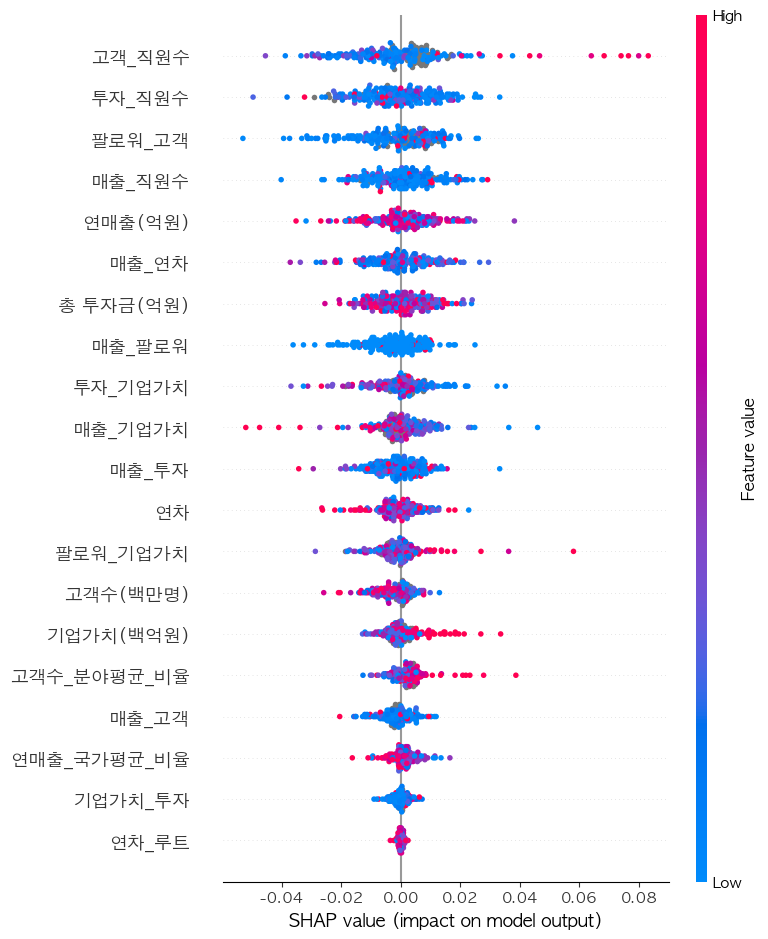

In [27]:
import shap
import matplotlib.pyplot as plt

# macOS: AppleGothic ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # ÎßàÏù¥ÎÑàÏä§ Íπ®Ïßê Î∞©ÏßÄ

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)


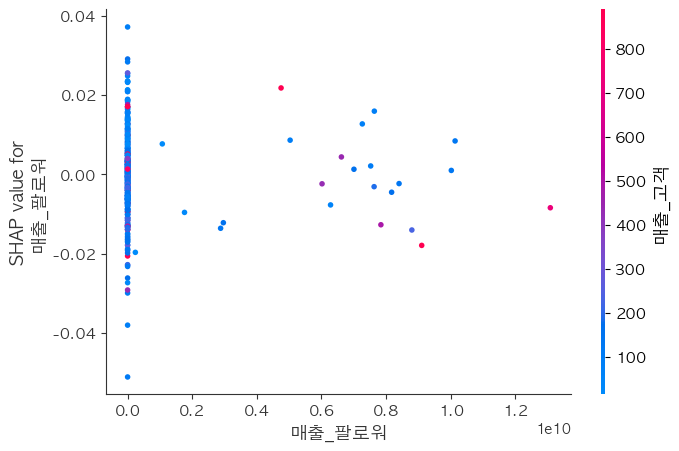

In [54]:
shap.dependence_plot("Îß§Ï∂ú_ÌåîÎ°úÏõå", shap_values, X_valid)


In [35]:
import pandas as pd

# Îëê ÌååÏùº Î∂àÎü¨Ïò§Í∏∞
file1 = '0414_09_submission.csv'
file2 = '0414_13_submission.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# 'ÏÑ±Í≥µÌôïÎ•†' Ïª¨Îüº Í∏∞Ï§ÄÏúºÎ°ú ÌèâÍ∑† Í≥ÑÏÇ∞
df_ensemble = df1.copy()
df_ensemble['ÏÑ±Í≥µÌôïÎ•†'] = (df1['ÏÑ±Í≥µÌôïÎ•†'] + df2['ÏÑ±Í≥µÌôïÎ•†']) / 2

# ÏÉàÎ°úÏö¥ Ï†úÏ∂ú ÌååÏùºÎ°ú Ï†ÄÏû•
df_ensemble.to_csv('0414_ensemble_submission.csv', index=False, encoding='utf-8-sig')
